In [1]:
import torch, os
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

<h3> Function for loading Images and Normalizing Values </h3>

In [ ]:
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

def read_images_and_labels(img_dir, label_file):
    with open(label_file, 'r') as f:
        labels = [int(word.strip()) for word in f.read().split("\n") if word.strip()]

    labels = [label - 1 for label in labels]  
    unique_labels = sorted(set(labels))  
    final_data = []
    for label in unique_labels:
        matching_files = [
            f for f in os.listdir(img_dir)
            if f.startswith(f"{label + 1}_image_") and f.endswith('.jpg')
        ]
        
        for matching_file in matching_files:
            image_path = os.path.join(img_dir, matching_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            if image is not None:
                final_data.append((image, label))

    images, labels = zip(*final_data)
    images = np.array(images, dtype="float32") / 255.0 
    labels = np.array(labels, dtype="int32")

    return images, labels


In [ ]:
path ="train_data"
path1 ="train_labels.txt"
images_data= read_images_and_labels(path,path1)
images_data

(array([[[[0.56078434, 0.7607843 , 0.76862746],
          [0.5529412 , 0.7529412 , 0.7607843 ],
          [0.5372549 , 0.7372549 , 0.74509805],
          ...,
          [0.79607844, 0.8235294 , 0.92941177],
          [0.7647059 , 0.7764706 , 0.8862745 ],
          [0.8235294 , 0.8392157 , 0.9372549 ]],
 
         [[0.54901963, 0.7490196 , 0.75686276],
          [0.5529412 , 0.7529412 , 0.7607843 ],
          [0.54901963, 0.7490196 , 0.75686276],
          ...,
          [0.8235294 , 0.84313726, 0.9411765 ],
          [0.83137256, 0.84705883, 0.9411765 ],
          [0.8039216 , 0.81960785, 0.9137255 ]],
 
         [[0.54901963, 0.74509805, 0.74509805],
          [0.56078434, 0.75686276, 0.75686276],
          [0.5686275 , 0.7607843 , 0.76862746],
          ...,
          [0.8352941 , 0.85490197, 0.9372549 ],
          [0.827451  , 0.8509804 , 0.9254902 ],
          [0.8235294 , 0.8392157 , 0.9098039 ]],
 
         ...,
 
         [[0.15294118, 0.13333334, 0.12156863],
          [0.08627

In [4]:
path ="val_data"
path1 ="val_labels.txt"
val_data= read_images_and_labels(path,path1)
val_data

(array([[[[0.09019608, 0.30588236, 0.5058824 ],
          [0.09019608, 0.30588236, 0.5058824 ],
          [0.09411765, 0.30588236, 0.5137255 ],
          ...,
          [0.03921569, 0.23137255, 0.40392157],
          [0.03921569, 0.23137255, 0.40392157],
          [0.03921569, 0.23137255, 0.40392157]],
 
         [[0.08235294, 0.29803923, 0.49803922],
          [0.08627451, 0.3019608 , 0.5019608 ],
          [0.09019608, 0.3019608 , 0.50980395],
          ...,
          [0.03529412, 0.22745098, 0.4       ],
          [0.03529412, 0.22745098, 0.4       ],
          [0.03529412, 0.22745098, 0.4       ]],
 
         [[0.07843138, 0.2901961 , 0.49803922],
          [0.08235294, 0.29411766, 0.5019608 ],
          [0.08627451, 0.29803923, 0.5058824 ],
          ...,
          [0.02745098, 0.21960784, 0.39215687],
          [0.03137255, 0.22352941, 0.39607844],
          [0.03137255, 0.22352941, 0.39607844]],
 
         ...,
 
         [[0.44705883, 0.5686275 , 0.65882355],
          [0.44705

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def preprocess_images(images):
    return np.array([cv2.resize(img, (224, 224)) for img in images])


train_images = np.array([img for img in images_data[0]])
train_labels = np.array([lbl for lbl in images_data[1]])
val_images = np.array([img for img in val_data[0]])
val_labels = np.array([lbl for lbl in val_data[1]])


train_images = preprocess_images(train_images)
val_images = preprocess_images(val_images)


num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)


train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


train_generator = train_datagen.flow(train_images, train_labels, batch_size=16, shuffle=True)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(val_images, val_labels, batch_size=16, shuffle=True)



base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)


epochs = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)




Epoch 1/10
188/188 [==============================] - 1879s 10s/step - loss: 2.8669 - accuracy: 0.3347 - val_loss: 0.9699 - val_accuracy: 0.8200
Epoch 2/10
188/188 [==============================] - 1916s 10s/step - loss: 1.0454 - accuracy: 0.7700 - val_loss: 0.2660 - val_accuracy: 0.9417
Epoch 3/10
188/188 [==============================] - 1854s 10s/step - loss: 0.4827 - accuracy: 0.9000 - val_loss: 0.1613 - val_accuracy: 0.9600
Epoch 4/10
188/188 [==============================] - 1713s 9s/step - loss: 0.2580 - accuracy: 0.9493 - val_loss: 0.1315 - val_accuracy: 0.9717
Epoch 5/10
188/188 [==============================] - 1782s 9s/step - loss: 0.1930 - accuracy: 0.9650 - val_loss: 0.1249 - val_accuracy: 0.9600
Epoch 6/10
188/188 [==============================] - 2039s 11s/step - loss: 0.1626 - accuracy: 0.9657 - val_loss: 0.0908 - val_accuracy: 0.9783
Epoch 7/10
188/188 [==============================] - 1822s 10s/step - loss: 0.1199 - accuracy: 0.9790 - val_loss: 0.0936 - val_accu

In [ ]:
model.save("saved_model.keras")

1/1 [==============================] - 2s 2s/step


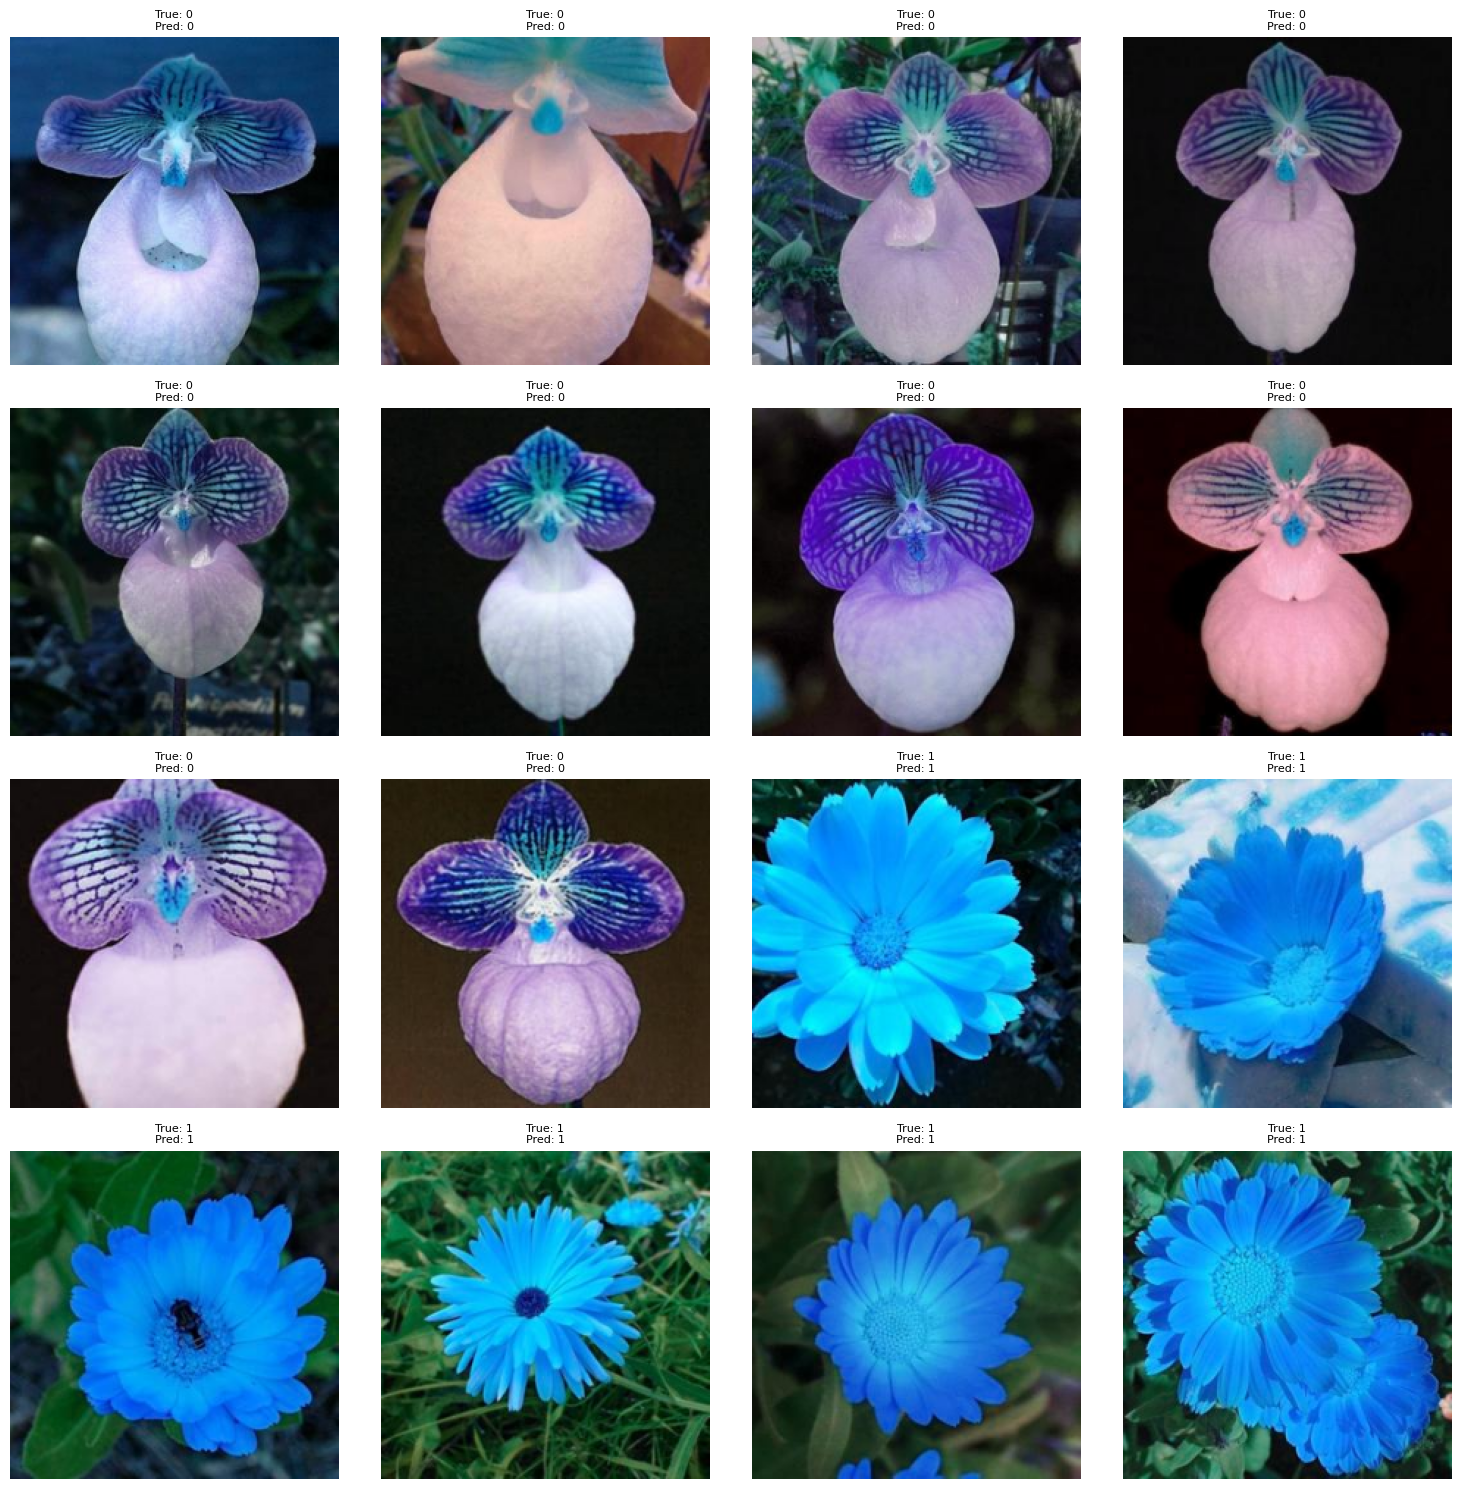

In [ ]:
def sample_predictions(images, true_labels, predictions, class_names):
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()  
    
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow((images[i] * 255).astype("uint8")) 
            ax.set_title(
                f"True: {class_names[true_labels[i]]}\nPred: {class_names[predictions[i]]}",
                fontsize=8
            )
            ax.axis("off")
        else:
            ax.axis("off")  
            
    plt.tight_layout()
    plt.show()

# Get predictions on validation data
val_images_sample = val_images[:16]
val_labels_sample = val_labels[:16]
predictions = np.argmax(model.predict(val_images_sample), axis=1)

# Visualize predictions
sample_predictions(
    val_images_sample,
    np.argmax(val_labels_sample, axis=1),
    predictions,
    class_names=list(range(num_classes))
)


In [ ]:
loaded_model = tf.keras.models.load_model("saved_model.keras")

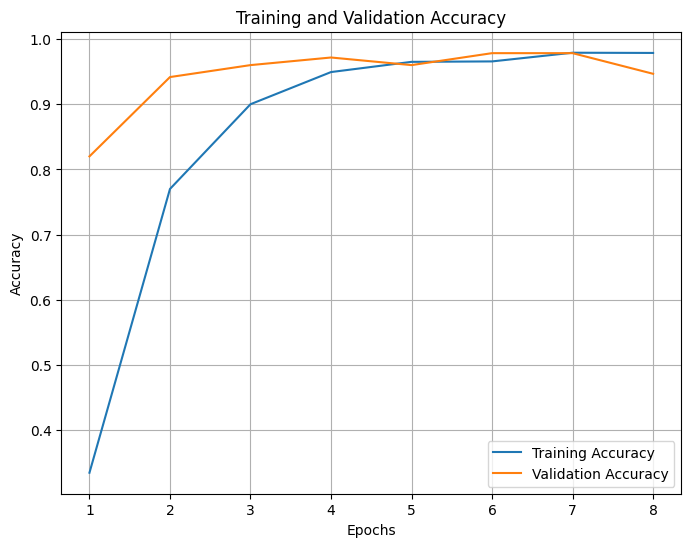

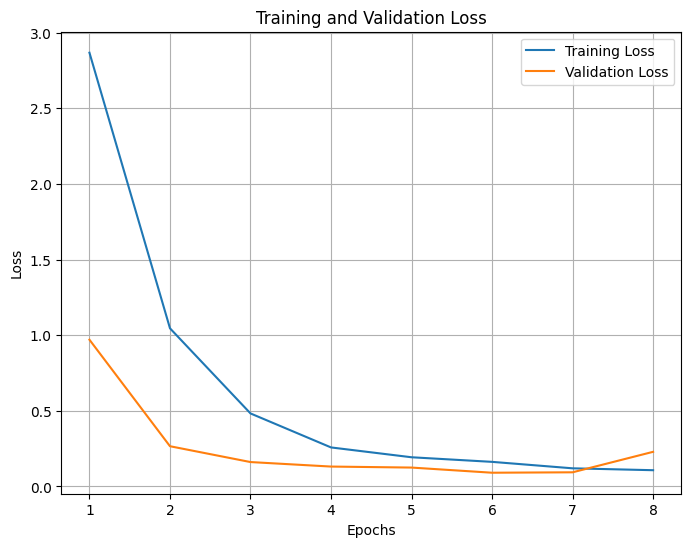

In [37]:
def plot_training_history(history):
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Plot Training and Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_training_history(history)


<h1> Test Bench : </h1>

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import accuracy_score


def test_bench(img_dir, label_file, model_file):

    test_data = read_images_and_labels(img_dir, label_file)

    test_images = np.array([img for img in test_data[0]])
    test_labels = np.array([lbl for lbl in test_data[1]])
    test_images = preprocess_images(test_images)
    test_model = tf.keras.models.load_model(model_file)
    
    print("Model loaded successfully.")

    predictions = test_model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(test_labels, predicted_classes)
    print(f"Accuracy on the provided dataset: {accuracy * 100:.2f}%")

    return predicted_classes, accuracy


<h1> Test Bench </h1>

In [36]:
# Change the following file paths to the folder and run the cell to execute the test bench
img_dir = "val_data"
label_file = "val_labels.txt"
model_file = "trained_model.keras"

# Run the test bench
predicted_classes, accuracy = test_bench(img_dir, label_file, model_file)


Model loaded successfully.
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001DFDC8E6D40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001DFDC8E6D40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experi